In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import pandas as pd
from scipy.stats import zscore


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

!pip install xgboost lightgbm catboost

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

In [141]:
aditya_df = pd.read_csv('data_file.csv')
aditya_df.head()

,Unnamed: 0,name,molweight,critical temperature (K),acentric factor,boiling point (K)
0,1,(+)-a-pinene,136.23704,647.00,0.341,428.65
1,2,(+)-camphene,136.23704,638.00,0.296,432.65
2,3,(-)-a-pinene,136.23704,647.00,0.341,429.35
3,4,(-)-b-citronellol,156.26820,656.59,0.612,498.65
4,5,(-)-camphene,136.23704,638.00,0.296,439.95


In [142]:
aditya_df.drop_duplicates(inplace=True)


Unnamed: 0                  0
name                        0
molweight                   0
critical temperature (K)    0
acentric factor             0
boiling point (K)           0
dtype: int64


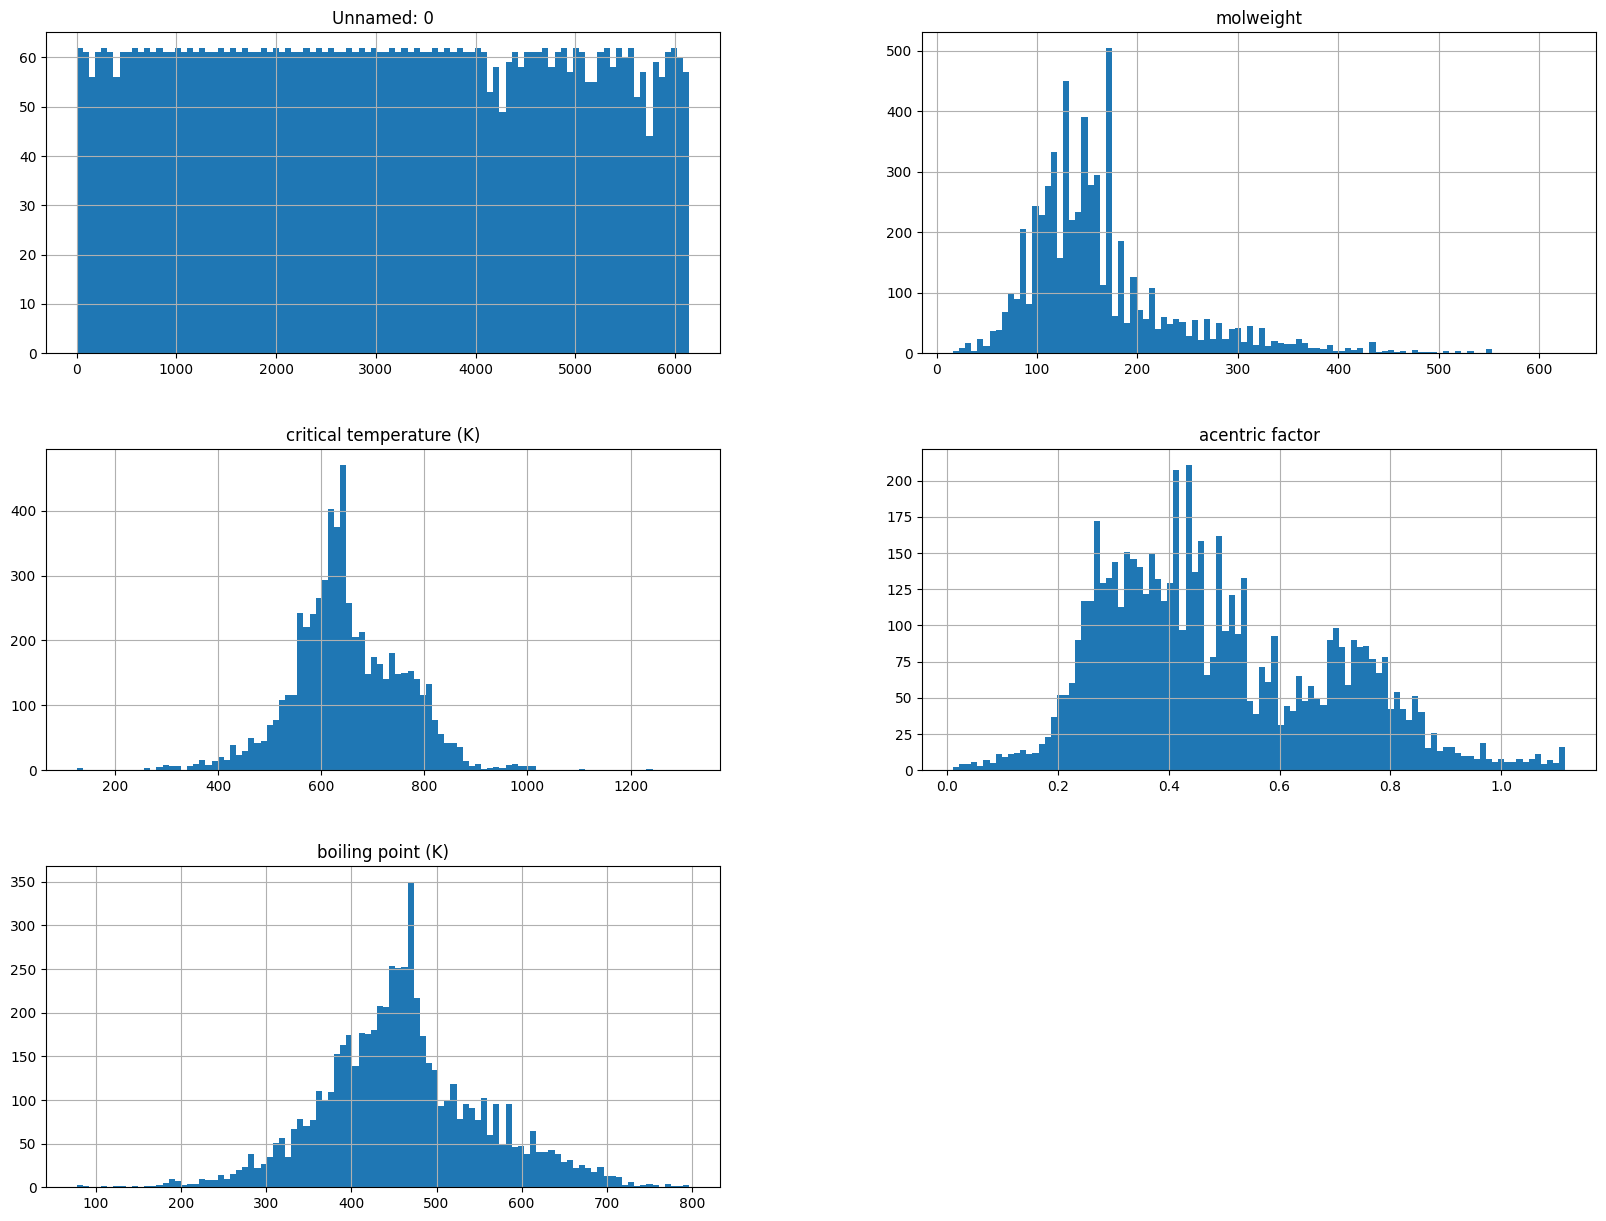

In [143]:


aditya_df.isnull().sum()
aditya_df.isna().sum()
print(aditya_df.isin([np.inf, -np.inf]).sum())
aditya_df.hist(bins=100, figsize=(20,15))
plt.show()


In [144]:
numeric_cols = aditya_df.select_dtypes(include=np.number).columns
aditya_df = aditya_df[numeric_cols]
aditya_df = aditya_df.loc[:, ~aditya_df.columns.str.contains('^Unnamed')]




In [145]:
aditya_df.head()

,molweight,critical temperature (K),acentric factor,boiling point (K)
0,136.23704,647.00,0.341,428.65
1,136.23704,638.00,0.296,432.65
2,136.23704,647.00,0.341,429.35
3,156.26820,656.59,0.612,498.65
4,136.23704,638.00,0.296,439.95


In [146]:

print(aditya_df.shape)
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered


for col in aditya_df.columns.tolist():
    aditya_df = remove_outliers_iqr(aditya_df, col)

print(aditya_df.shape)


(6031, 4)
(5308, 4)


Selected Features: ['molweight', 'critical temperature (K)']


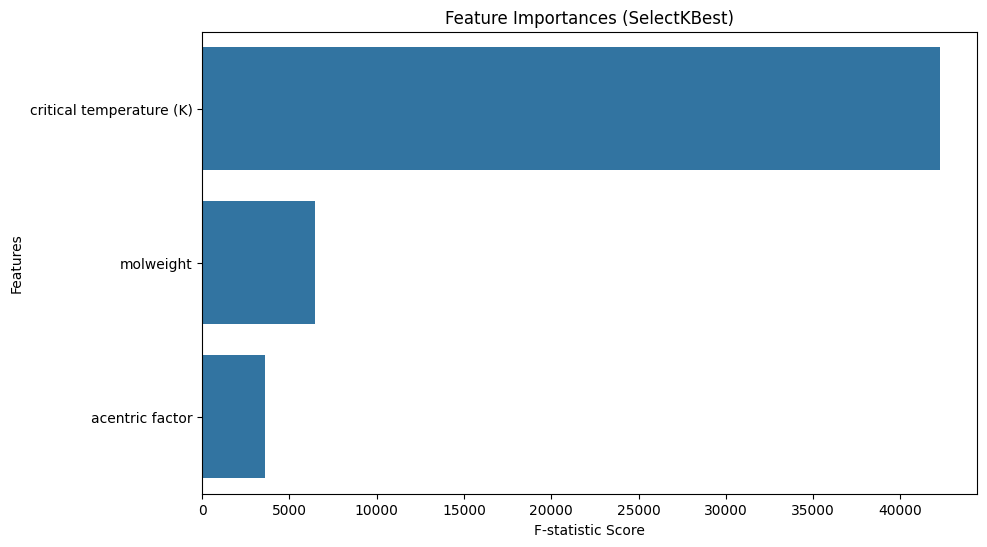

In [147]:
from sklearn.feature_selection import SelectKBest, f_regression
X = aditya_df.drop('boiling point (K)', axis=1)
y = aditya_df['boiling point (K)']
selector = SelectKBest(score_func=f_regression, k=2)
X_new = selector.fit_transform(X, y)
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_feature_indices].tolist()
print("Selected Features:", selected_feature_names)

importances = selector.scores_
feature_names = X.columns
# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances (SelectKBest)')
plt.xlabel('F-statistic Score')
plt.ylabel('Features')
plt.show()


In [148]:


X = aditya_df[['molweight', 'critical temperature (K)']]


In [149]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 453.309554405624
R-squared: 0.9199021719736499


In [150]:




ridge_param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
y_pred_ridge = ridge_grid.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Regression - Best alpha: {ridge_grid.best_params_}")
print(f"Ridge Regression - Mean Squared Error: {mse_ridge}")
print(f"Ridge Regression - R-squared: {r2_ridge}")


lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(Lasso(), lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
y_pred_lasso = lasso_grid.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso Regression - Best alpha: {lasso_grid.best_params_}")
print(f"Lasso Regression - Mean Squared Error: {mse_lasso}")
print(f"Lasso Regression - R-squared: {r2_lasso}")


elastic_param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
elastic_grid = GridSearchCV(ElasticNet(), elastic_param_grid, cv=5, scoring='neg_mean_squared_error')
elastic_grid.fit(X_train, y_train)
y_pred_elastic = elastic_grid.predict(X_test)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
r2_elastic = r2_score(y_test, y_pred_elastic)
print(f"Elastic Net Regression - Best parameters: {elastic_grid.best_params_}")
print(f"Elastic Net Regression - Mean Squared Error: {mse_elastic}")
print(f"Elastic Net Regression - R-squared: {r2_elastic}")



Ridge Regression - Best alpha: {'alpha': 100}
Ridge Regression - Mean Squared Error: 453.3100245186118
Ridge Regression - R-squared: 0.9199020889067282
Lasso Regression - Best alpha: {'alpha': 1}
Lasso Regression - Mean Squared Error: 453.3339579230719
Lasso Regression - R-squared: 0.9198978599781829
Elastic Net Regression - Best parameters: {'alpha': 10, 'l1_ratio': 0.1}
Elastic Net Regression - Mean Squared Error: 453.52272480949557
Elastic Net Regression - R-squared: 0.9198645056897967


Random Forest Regression - Mean Squared Error: 218.35423768931454
Random Forest Regression - R-squared: 0.961417755241899


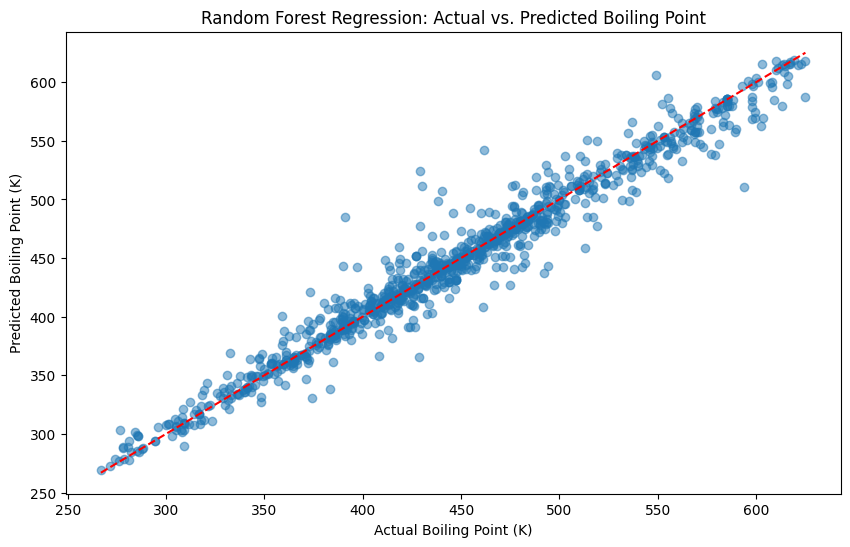

In [151]:
#best model

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regression - Mean Squared Error: {mse_rf}")
print(f"Random Forest Regression - R-squared: {r2_rf}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Boiling Point (K)")
plt.ylabel("Predicted Boiling Point (K)")
plt.title("Random Forest Regression: Actual vs. Predicted Boiling Point")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()


In [152]:
def predict_boiling_point(molweight, critical_temp):


  input_data = pd.DataFrame({'molweight': [molweight], 'critical temperature (K)': [critical_temp]})


  predicted_boiling_point = rf_model.predict(input_data)[0]

  return predicted_boiling_point

print(predict_boiling_point(44.01, 304.13));


270.24780000000027
